# Troubleshooting

Keep in mind this list is incomplete, it is just issues that I have run into and how I fixed them. If your issue is not resolved by this guide, you can message the lenstronomy slack channel or see the lenstronomy github!

### Patterns in residuals: 
##### Issue: Bulls-eye pattern where objects are
Your PSF model is not a good fit.

_Fixes:_
* Check that the fwhm for your psf model is correct
* Try making a PSF pixel model from a bright star in the near field
* You can do an iterative approach to the psf where lenstronomy reconstructs it, but it comes at the cost of a much higher computing time

##### Issue:  Half & Half pattern where objects are
Your modeled position does not match the observed position.
___This may be a sign that the geometry of your system is not fitting well!___

_Fixes:_
* How accurate are your position measurements? Should you remeasure? 
    * Using DS9 software and the contours feature may help to remeasure
    * Try letting your image positions be free parameters and vary within a reasonable uncertainty (ex. 0.1 arcsec depending on your camera resolution)
* When you solve the lens equation using your results, does the source position match the image positions?
    * Go back and fix all positions (lens and images) and check that lens equation is satisfied

##### Issue: Residuals look mostly white or very faint: 
Your background_rms value is too high.

_Fixes:_
* Ensure that your background_rms value is correct. 
    * You can get an estimate of the background_rms by taking a section of your image that is only background noise and taking the root mean square of all the pixels in that area. This should be done separately for each band you are using.


##### Issue: Residuals show a red dot where image position is surrounded by blue: 
***If the blue traces an arc/elliptical shape around the lens:***
then there is likely an extended source behind the point source.

_Fix:_
* Add ‘source_light’ parameters to your model and run again.

***If the blue is a round shape or overlaps with the lens:***
then this may be a foreground galaxy or an additional lensing galaxy.

_Fixes:_
* try running model with this object as another lensing galaxy
* try running model with this object masked or not included in your image/lens list

##### Issue: Non-white residuals in a masked region:
You are masking out your data, but not your likelihood in the masked region.
_Fix:_
* Set image_likelihood_mask_list = [* *2d arrays of your masked images* *]
* Add image_likelihood_mask_list to your ModelPlot class and kwargs_likelihood

### The model is returning non-physical values:
##### Issue: Check Matched Source Position = False:
Based on the mass model and image positions in your results, the lens equation found that the source positions did not align with each other within the given tolerance.

_Fixes:_
* in kwargs_likelihood set 'check_matched_source_position': True
* check that the tolerance is reasonable considering the uncertainties in your measurements
* in kwargs_likelihood set ‘force_no_add_image’: False.
    * This allows your model to add another image if that is what gives it the best fit. Make sure you have your critical curves and caustics on so you can determine if this extra image has a good explanation as to why it does not show up in your data (demagnified, too close to another object, etc.)

##### Issue: Check Positive Flux = False:
Your model is returning a negative flux for at least one of your objects.

_Fix:_
* in kwargs_likelihood set ‘check_positive_flux’: True. This will add a punishing factor to models that return a negative flux.

### Corner Plot:
##### Issue: One or more parameters are convering right on the edge of the upper or lower bound:

Fixes: 
* Are your bounds realistic for the parameter? try widening the bounds to see if it will converge on the same answer
    * if it continues to converge right on the edge of the bound after expanding it, then try expanding the bounds to an extreme value.
        * If the parameter *still* converges right on the edge, then the issue is not the bounds but rather the model cannot come up with a realistic fit.
        * If the parameter converges, then evaluate whether the result is realistic and physically possible. 
    * if the parameter converges in the middle after expanding the bounds, then ask yourself if the result makes physical sense for the system.

##### Issue: There are multiple peaks in one or more parameters histogram

Either there is degeneracy in your model, or the model is not fitting well.

Fixes: 
* Check that the bounds are realistic for the parameter(s)
    * try decreasing the bounds to decrease degeneracy
* Try decreasing the number of free parameters
    * You can do this by keeping more parameters fixed or by simplifying your model (ex. Removing external shear from the model)

### Model is still not fitting well: 
Other things to try: 
* Try modeling only a single band that has the most information (often the reddest band has the most information and the least noise)
    * If your model begins to fit well on a single band, then you may have an issue with the alignment of the multiple images. 
        * Lenstronomy can align the images by running a PSO with the coordinate systems as free parameters. Get a fit for the single band, and use the alignment fitting to align the other bands and try to fit again. 
* Go back a step (or two) and see if you are running into the same problem at that step. Try to fix it there before moving on.

This list is very incomplete and these are just things I ran into while modeling. Talk to someone or message the lenstronomy slack channel to get more help!

### More General Notes and Tips I Learned:
* __Always include the critical curves and caustics!__ It is very illuminating. Include in your simulation and after your model to check the results.
* __Put checks in your model that you can see!__ A lot goes on behind the scenes so it is important to explicitly show some extra checks to ensure that everything is working as planned. Checks that helped me: 
    * Positive fluxes?
    * Source position matches? (the lens equation is satisfied)
    * Residuals have no patterns?
        * Make sure your background_rms is correct so you can see all the residuals
* __Make sure you are showing each band separately__. Lenstronomy only shows the first band in multi_band_list unless explicitly stated
* __Do the results make physical sense and are they likely?__ For example, an *extremely* elliptical model is *possible*, but probably not likely
* __The simple way is (almost) always better (basically, don’t overfit your model!)__ You could theoretically fit anything in the DES catalogue to a lens model because of how many free parameters there are, so just because you *can* fit something, doesn't mean it is a lensed system.
    * The more complexity you add to your model...
        1. the less likely it is a lensed system
        2. the less likely it is that you will be able to use the results from your lens modeling to do the science you want to do
* __It is okay if the PSO does not converge,__ it is just a starting point for the MCMC
    * That being said, give the PSO enough time (I usually use a minimum of 400 iterations and 400 particles) to get a good starting point for the MCMC. It is a good sign if your PSO converges!
    * 200 burn and 600 run worked well for my MCMC


From the previous notebook, Step 5, we saw the 'bulls-eye' pattern around our objects, so we know the PSF is not fitting well. Since we do not the data from the near field to look for a bright star as a PIXEL PSF model, we will use the iterative approach. 

To have lenstronomy reconstruct the PSF model from the data, we will first need to run a PSO with the PSF model as our 'free variable'. Then we will plot the original PSF and the reconstructed PSF to see the differences. Finally, we will run the model again as we did the first time, with a second PSO and MCMC.

In [4]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import corner
import astropy as ap
from astropy.io import fits
import astropy.io.fits as pyfits
from astropy.visualization import astropy_mpl_style
import pandas as pd
import math
import statistics
import scipy.ndimage as ndimage
import lenstronomy.Util.kernel_util as kernel_util
import lenstronomy.Plots.plot_util as plot_util
from lenstronomy.Util import util
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Plots import chain_plot
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Util import mask_util
from lenstronomy.ImSim.image_linear_solve import ImageLinearFit
from memory_profiler import memory_usage
from lenstronomy.Plots.lens_plot import lens_model_plot
from lenstronomy.LensModel.lens_model import LensModel
plt.style.use(astropy_mpl_style)
%matplotlib inline


In [5]:
# All of our functions (just copied over from Step 5)
def get_data(filename):
    """
    Input: filename
    Output: data table and image array
    """
    hdu_list = fits.open(filename)  # open
    data = pd.DataFrame(hdu_list[2].data)  # get dataframe data
    image = hdu_list['IMAGE'].data  # get image data
    hdu_list.close()  # close
    return data, image


def plot_image(image_array):
    """
    Input: image array
    Output: plot of image with no grid
    """
    fig, ax = plt.subplots()
    ax.imshow(image_array, origin='lower')
    ax.set_xticks([])
    ax.set_xticks([])
    ax.grid(False)
    plt.show()
    plt.close()

def approx_theta_E(center_x, center_y, x_images, y_images):
    """
    Input: Lens position (center_x, center_y) and image positions
    Output: estimated theta_E
    ** units must be in arcsec **
    """
    d = []

    for i in range(0, len(x_images)):
        x = float(x_images[i])
        y = float(y_images[i])
        x = center_x - x
        y = center_y - y
        dist = math.sqrt(x ** 2 + y ** 2)
        d.append(dist)

    theta_E = statistics.mean(d)
    print(f"'Estimated theta_E': {round(theta_E, 2)}")
    return theta_E

def model_plot_all_bands_withCC(modelPlot, kwargs_result):
    # get lens model and image positions from results
    kwargs_lens_results = kwargs_result.get('kwargs_lens')  # set kwargs
    lensModel = LensModel(lens_model_list=['SIE'])  # set class

    x_images = kwargs_result.get('kwargs_ps')[0].get('ra_image')
    y_images = kwargs_result.get('kwargs_ps')[0].get('dec_image')
    kwargs_ps_results = [{'ra_image': x_images, 'dec_image': y_images}]  # set kwargs
    pointSource = PointSource(point_source_type_list=['LENSED_POSITION'], lensModel=lensModel)  # set class

    # find source position from image positions
    x_source_list, y_source_list = lensModel.ray_shooting(x_images, y_images, kwargs_lens_results)
    
    # optional check for ray traced source positions
    print('The ray traced source positions are: ')
    print(f'ra: {x_source_list}')
    print(f'dec: {y_source_list}') 

    # set up figure
    f, axes = plt.subplots(3, 4, figsize=(20, 15))  # make figure 3x4

    # set row names: names must be in same order as multi_band_list
    band_names = ['G', 'R', 'I']
    for index, band_name in enumerate(band_names):
        axes[index, 0].set_title(str(band_name)+'-Band')  # set row title

        # plot observed, reconstructed, and normalized residual plots
        modelPlot.data_plot(ax=axes[index, 0], band_index=index)
        modelPlot.model_plot(ax=axes[index, 1], image_names=True, band_index=index)
        modelPlot.normalized_residual_plot(ax=axes[index, 2], v_min=-6, v_max=6, band_index=index)
        
        # check that model is returning physical quantities: 
        check_impos = pointSource.check_image_positions(kwargs_ps_results, kwargs_lens_results, tolerance=0.01)
        check_flux = pointSource.check_positive_flux(kwargs_ps_results)
        print(f'Check Positions: {check_impos}')
        print(f'Check Fluxes: {check_flux}')

        # settings for critical curves and caustics plot
        kwargs_lens_plot = {'with_caustics': True, 
                            'fast_caustic': True, 
                            'point_source': True,
                            'with_convergence': True,
                            'numPix': numPix,
                            'deltaPix': deltaPix,
                            'coord_inverse': False} 

        # plot critical curves and caustics
        lens_model_plot(axes[index, 3], lensModel, 
                        kwargs_lens_results,
                        sourcePos_x=statistics.mean(x_source_list),
                        sourcePos_y=statistics.mean(y_source_list),
                        **kwargs_lens_plot)

    plt.show()
    plt.close()


# background_rms functions
def get_hist_stats(flat_image):
    """
    Input: 1d numpy array of image (flattened image)
           note: to flatten an image use '1d_array = 2d_array.flatten()'
    Output: number of bins for histogram based on spread of data,
            integer values of min and max (used for range of x-axis)
            root mean square value
    """
    min_int = math.floor(np.amin(flat_image))  # round min down to int
    max_int = math.ceil(np.amax(flat_image))  # round max up to int
    Bins = abs(min_int)+max_int  # num bins = one per integer value
    rms = np.sqrt(np.mean(flat_image**2))  # calculate rms
    return Bins, min_int, max_int, rms


def get_rms_fast(filename, coadd_id, crop):
    """
    Short Version:
    Input: filename, coadd_id of image, and background region
           region = crop = [[x_lower, x_upper], [y_lower, y_upper]]
    Output: rms_list (g,r,i)
    """
    data, image = get_data(filename)
    row = data[data['COADD_OBJECT_ID'] == coadd_id].index[0]

    # crop g,r,i bands to region
    g_crop = image[row, 0, crop[0][0]:crop[0][1], crop[1][0]:crop[1][1]]
    r_crop = image[row, 1, crop[0][0]:crop[0][1], crop[1][0]:crop[1][1]]
    i_crop = image[row, 2, crop[0][0]:crop[0][1], crop[1][0]:crop[1][1]]

    # list of flattened images (1d image arrays)
    band_flats = [g_crop.flatten(), r_crop.flatten(), i_crop.flatten()]
    rms_list = []  # rms values will be saved here and returned

    # loop to get rms for each band
    for index, flat_image in enumerate(band_flats):
        _, _, _, rms = get_hist_stats(flat_image)  # get rms
        rms_list.append(rms)  # save rms

    return rms_list


def add_mask(band, kwargs_data, kwargs_psf, mask_2d):
    """
    Input: band (g,r,i) plus corresponding kwargs_data and kwargs_psf,
           kwargs_numerics
    Output: kwargs_data with masked image
    """
    # settings
    data_class = ImageData(**kwargs_data)
    psf_class = PSF(**kwargs_psf)
    kwargs_numerics = {'supersampling_factor': 1,
                       'supersampling_convolution': False}

    imageFit = ImageLinearFit(data_class=data_class,
                              psf_class=psf_class,
                              kwargs_numerics=kwargs_numerics,
                              likelihood_mask=mask_2d)
    # apply mask to image
    mask_1d = imageFit.image2array_masked(band)
    masked_image = imageFit.array_masked2image(mask_1d)

    # update kwargs_data with masked image
    kwargs_data.update({'image_data': masked_image})

    return kwargs_data, masked_image

In [6]:
# set filenames
filepath = '/Users/gilliancartwright/Desktop/summerproject/Data/'  # personal file path
filename = filepath + 'Quasars.fits'

# get data and set coadd_id
data, image = get_data(filename)
coadd_id = 1146879846

# get background_rms
rms_list = get_rms_fast(filename, coadd_id, [[0, 10], [0, 10]])

# DES camera specifics
exp_time = 90.  # exposure time
numPix = 46  # number of pixels in image
deltaPix = 0.2637  # pixel size in arcsec
psf_type = 'GAUSSIAN'  # again, we start with a gaussian estimate

# measure image and lens positions:
x_images = [-0.60, 0.59]
y_images = [-0.70, -0.07]
center_x = -0.35
center_y = 0.37

# approximate an eistein radius:
theta_E = approx_theta_E(center_x, center_y, x_images, y_images)

# and add a mask
mask_list = [{'mask_x': 3.3 , 'mask_y': -4.09, 'mask_r':3},
             {'mask_x': -5.71,'mask_y': 0.38, 'mask_r': 1},  # adding a few more masks
             {'mask_x': -4.6,'mask_y': -0.95, 'mask_r': 1.5}]

'Estimated theta_E': 1.07


In [7]:
# This time, we will need to translate our gaussian psf estimate into a PIXEL model,
# this function sets the PIXEL gaussian estimate for one band
def set_gauss_psf(fwhm):
    """
    Input: fwhm
    Output: Pixel type kwargs_psf with gaussian kernel
    
    """
    # set GAUSSIAN psf as before
    kwargs_psf = {'psf_type': 'GAUSSIAN',
                  'fwhm': fwhm,
                  'pixel_size': deltaPix,
                  'truncation': 4}

    # convert GAUSSIAN type to kernel for PIXEL type
    psf = PSF(**kwargs_psf)
    kernel = psf.kernel_point_source
    error_map = psf.psf_error_map

    # set type as PIXEL with GAUSSIAN kernel and error map
    kwargs_psf_pix = {'psf_type': 'PIXEL', 'pixel_size': deltaPix,
                      'fwhm': fwhm, 'kernel_point_source': kernel,
                      'psf_error_map': error_map}
    return kwargs_psf_pix


In [10]:
# MODEL. 
def model(coadd_id, kwargs_lens_initial, kwargs_light_initial,
          x_images, y_images, psf_type, rms_list, mask_list):
    """
    INPUT: coadd_id,
           initial lens mass and light model params,
           image positions in arcsec,
           psf choice (GAUSSIAN or PIXEL),
           list of background rms values (ordered G,R,I),
           list of masks or None
    OUTPUT: Reconstructed PSF, (NEW!)
            RGB image,
            observed image, modeled image, normalized residuals, critical curves and caustics (each band)
            and results of PSO and MCMC fitting
    """
    # Image data
    data, image = get_data(filename)
    # index data frame by coadd_id
    row = data[data['COADD_OBJECT_ID'] == coadd_id].index[0]

    g = image[row, 0, :, :] # get image array
    r = image[row, 1, :, :]
    i = image[row, 2, :, :]

    fwhm_g = data.iloc[row, 27] # get fwhm
    fwhm_r = data.iloc[row, 28]
    fwhm_i = data.iloc[row, 29]

    rms_g = rms_list[0]  # get background_rms
    rms_r = rms_list[1]
    rms_i = rms_list[2]

    # set models to use
    # input for point source is image positions, not source position
    lens_model_list = ['SIE']
    lens_light_model_list = ['SERSIC_ELLIPSE']
    point_source_list = ['LENSED_POSITION']

    # generate coordinate grid and image properties
    ra_grid, dec_grid, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ = util.make_grid_with_coordtransform(numPix, deltaPix, subgrid_res=1, center_ra=0, center_dec=0, inverse=False)

    # generate image data for each band
    kwargs_data_g = {'background_rms': rms_g,  # calculated from background section
                     'exposure_time': exp_time,  # from DES camera
                     'ra_at_xy_0': ra_at_xy_0,
                     'dec_at_xy_0': dec_at_xy_0,
                     'transform_pix2angle': Mpix2coord,  # coords in ra, dec
                     'image_data': g}  # 2d image array

    kwargs_data_r = {'background_rms': rms_r,
                     'exposure_time': exp_time,
                     'ra_at_xy_0': ra_at_xy_0,
                     'dec_at_xy_0': dec_at_xy_0,
                     'transform_pix2angle': Mpix2coord,
                     'image_data': r}

    kwargs_data_i = {'background_rms': rms_i,
                     'exposure_time': exp_time,
                     'ra_at_xy_0': ra_at_xy_0,
                     'dec_at_xy_0': dec_at_xy_0,
                     'transform_pix2angle': Mpix2coord,
                     'image_data': i}
    
    # set our initial PSF to the same gaussian estimate using the fwhm
    kwargs_psf_g = set_gauss_psf(fwhm_g)
    kwargs_psf_r = set_gauss_psf(fwhm_r)
    kwargs_psf_i = set_gauss_psf(fwhm_i)
    
    # Option to add mask(s)
    if mask_list:
        # get 2d grid for ra, dec
        ra_grid_2d = util.array2image(ra_grid)
        dec_grid_2d = util.array2image(dec_grid)

        # add each mask from mask_list
        for index in range(len(mask_list)):
            # generate mask
            mask = mask_list[index]
            mask_2d = mask_util.mask_center_2d(center_x=mask.get('mask_x'),
                                               center_y=mask.get('mask_y'),
                                               r=mask.get('mask_r'),
                                               x_grid=ra_grid_2d,
                                               y_grid=dec_grid_2d)

            # add mask to each band
            kwargs_data_g, g = add_mask(g, kwargs_data_g, kwargs_psf_g, mask_2d)
            kwargs_data_r, r = add_mask(r, kwargs_data_r, kwargs_psf_r, mask_2d)
            kwargs_data_i, i = add_mask(i, kwargs_data_i, kwargs_psf_i, mask_2d)
        
        # apply mask to likelihood
        image_likelihood_mask_list = [g, r, i]
        
        # plot each band with mask(s) for reference
        plot_image(g)
        plot_image(r)
        plot_image(i)

    elif mask_list == None:
        pass
    else:
        print('Please add mask or set mask_list=None')


    # Settings for model
    kwargs_numerics = {'supersampling_factor': 1,
                       'supersampling_convolution': False}

    # combine models
    kwargs_model = {'lens_model_list': lens_model_list,
                    'lens_light_model_list': lens_light_model_list,
                    'point_source_model_list': point_source_list,
                    'additional_images_list': [False],
                    'fixed_magnification_list': [False]}  # not modeling flux ratios here

    num_images = len(x_images)  # number of images
    kwargs_constraints = {'num_point_source_list': [num_images],
                          'joint_lens_with_light': [[0, 0, ['center_x', 'center_y']]]}  # lens mass and light will vary together now

    kwargs_likelihood = {'check_bounds': True,  # punish models outside upper/lower bounds
                         'force_no_add_image': False,  # allow the model to add images
                         'image_position_uncertainty': 0.01,  # 1 sigma gaussian uncertainty in image positions
                         'check_matched_source_position': True,  # check that the image positions trace back to the same source position
                         'check_positive_flux': True,  # punish models with non-physical fluxes
                         'source_position_tolerance': 0.01,
                         'source_position_sigma': 0.01,
                         'image_likelihood': True,
                         'image_likelihood_mask_list': image_likelihood_mask_list  # apply mask to likelihood
                        }


    # Combine bands for modeling
    g_band = [kwargs_data_g, kwargs_psf_g, kwargs_numerics]
    r_band = [kwargs_data_r, kwargs_psf_r, kwargs_numerics]
    i_band = [kwargs_data_i, kwargs_psf_i, kwargs_numerics]
    multi_band_list = [g_band, r_band, i_band]
    kwargs_data_joint = {'multi_band_list': multi_band_list,
                         'multi_band_type': 'multi-linear'}

    # Add parameters to model:
    # lens
    kwargs_lens_fixed = [{}]  # fixed parameters
    kwargs_lens_init = [kwargs_lens_initial]  # initial input
    kwargs_lens_sigma = [{'theta_E': 0.1, 'e1': 0.05, 'e2': 0.05,
                          'center_x': 0.01, 'center_y': 0.01}]  # step sizes
    kwargs_lower_lens = [{'theta_E': theta_E - 0.7, 'e1': -0.5, 'e2': -0.5,
                          'center_x': center_x - 0.2, 'center_y': center_y - 0.2}]  # lower bounds
    kwargs_upper_lens = [{'theta_E': theta_E + 0.7, 'e1': 0.5, 'e2': 0.5,
                          'center_x': center_x + 0.2, 'center_y': center_y + 0.2}]  # upper bounds

    # lens light
    kwargs_lens_light_fixed = [{}]
    kwargs_lens_light_init = [kwargs_light_initial]
    kwargs_lens_light_sigma = [{'R_sersic': 0.1, 'n_sersic': 0.1,
                                'e1': 0.05, 'e2': 0.05,
                                'center_x': 0.01, 'center_y': 0.01}]
    kwargs_lower_lens_light = [{'R_sersic': 0.01, 'n_sersic': 0.01,
                                'e1': -0.5, 'e2': -0.5,
                                'center_x': center_x-0.2, 'center_y': center_y-0.2}]
    kwargs_upper_lens_light = [{'R_sersic': 11, 'n_sersic': 10.,
                                'e1': 0.5, 'e2': 0.5,
                                'center_x': center_x+0.2, 'center_y': center_y+0.2}]

    # point source image positions
    fixed_ps = [{}]
    kwargs_ps_init = [{'ra_image': x_images,'dec_image': y_images}]
    kwargs_ps_sigma = [{'ra_image': [0.01] * num_images,
                        'dec_image': [0.01] * num_images}]
    kwargs_lower_ps = [{'ra_image': [i-0.2 for i in x_images],
                        'dec_image': [i-0.2 for i in y_images]}]
    kwargs_upper_ps = [{'ra_image': [i+0.2 for i in x_images],
                        'dec_image': [i+0.2 for i in y_images]}]

    # combine params
    lens_params = [kwargs_lens_init,
                   kwargs_lens_sigma,
                   kwargs_lens_fixed,
                   kwargs_lower_lens,
                   kwargs_upper_lens]

    lens_light_params = [kwargs_lens_light_init,
                         kwargs_lens_light_sigma,
                         kwargs_lens_light_fixed,
                         kwargs_lower_lens_light,
                         kwargs_upper_lens_light]

    ps_params = [kwargs_ps_init,
                 kwargs_ps_sigma,
                 fixed_ps,
                 kwargs_lower_ps,
                 kwargs_upper_ps]

    kwargs_params = {'lens_model': lens_params,
                     'lens_light_model': lens_light_params,
                     'point_source_model': ps_params}

    ### THIS IS WHERE THINGS CHANGE! ###
    # Fitting
    # Combine everything from above for the fitting process
    fitting_seq = FittingSequence(kwargs_data_joint,
                              kwargs_model,
                              kwargs_constraints,
                              kwargs_likelihood,
                              kwargs_params)
    
    # General Settings
    particles = 400
    iterations = 400
    burn = 200
    run = 600
    
    # PSO Settings
    PSO_list = ['PSO', {'sigma_scale': 1.,
                        'n_particles': particles,
                        'n_iterations': iterations}]

    # PSF Reconstruction Settings
    kwargs_psf_iter = {'stacking_method': 'median',
                       'keep_psf_error_map': True,  # we don't have an error map so this doesn't matter
                       'psf_symmetry': 2,  # start with larger symmetry and work towards lower
                       'block_center_neighbour': 0.05,
                       'num_iter': 100,
                       'psf_iter_factor': 0.2}

    PSF_list = ['psf_iteration', kwargs_psf_iter]
    
    # MCMC Settings
    MCMC_list = ['MCMC', {'n_burn': burn, 'n_run': run,
                          'walkerRatio': 10, 'sigma_scale': .1}]

    # Now, we will run a PSO and the PSF reconstruction:
    fitting_kwargs_list = [PSO_list]  # PSO first
    chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)  # run PSO
    kwargs_result = fitting_seq.best_fit()  # set results

    # show first PSO results
    modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, image_likelihood_mask_list,
                          arrow_size=0.02, cmap_string="gist_heat")

    model_plot_all_bands_withCC(modelPlot, kwargs_result)

    # Reconstruct PSF
    fitting_kwargs_list = [PSF_list]
    chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)  # run PSF

    # update multi_band_list and kwargs_psf
    multi_band_list = fitting_seq.multi_band_list
    kwargs_psf_g_updated = multi_band_list[0][1]
    kwargs_psf_r_updated = multi_band_list[1][1]
    kwargs_psf_i_updated = multi_band_list[2][1]

    # show PSF comparison plots for each band
    subfigs = plt.figure().subfigures(3, 1)
    subfigs[0] = chain_plot.psf_iteration_compare(kwargs_psf_g_updated)
    subfigs[1] = chain_plot.psf_iteration_compare(kwargs_psf_r_updated)
    subfigs[2] = chain_plot.psf_iteration_compare(kwargs_psf_i_updated)

    # show model with updated PSF
    modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, image_likelihood_mask_list,
                          arrow_size=0.02, cmap_string="gist_heat")

    model_plot_all_bands_withCC(modelPlot, kwargs_result)
    
    # We will run one more PSF reconstruction, and then we are back to normal!
    kwargs_psf_iter.update({'psf_symmetry': 1})  # lower the PSF symmetry

    fitting_kwargs_list = [PSO_list, PSF_list, PSO_list,
                           # if needed, add PSF 3 here
                           MCMC_list]
    
    chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
    kwargs_result = fitting_seq.best_fit()
    
    # update multi_band_list and kwargs_psf
    multi_band_list = fitting_seq.multi_band_list
    kwargs_psf_g_updated = multi_band_list[0][1]
    kwargs_psf_r_updated = multi_band_list[1][1]
    kwargs_psf_i_updated = multi_band_list[2][1]

    # Show final results
    print(f"ra_images: {np.around(kwargs_result.get('kwargs_ps')[0].get('ra_image'), 2)}")
    print(f"dec_images: {np.around(kwargs_result.get('kwargs_ps')[0].get('dec_image'), 2)}")

    # plotting settings
    modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, image_likelihood_mask_list,
                          arrow_size=0.02, cmap_string="gist_heat")

    # plot RGB image
    rgb_image = ap.visualization.make_lupton_rgb(i, r, g, stretch=50, Q=10)
    plot_image(rgb_image)

    # plot observed, reconstructed, normalized residuals, and critical curves for each band
    model_plot_all_bands_withCC(modelPlot, kwargs_result)
    
    # Results of MCMC chain
    sampler_type, samples_mcmc, param_mcmc, dist_mcmc = chain_list[2]
    for i in range(len(chain_list)):
        chain_plot.plot_chain_list(chain_list, i)

    print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
    print("parameters in order: ", param_mcmc)
    print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])
    n_sample = len(samples_mcmc)
    print(n_sample)
    samples_mcmc_cut = samples_mcmc[int(n_sample * 1/2.):]

    n, num_param = np.shape(samples_mcmc_cut)
    plot = corner.corner(samples_mcmc_cut[:, :], labels=param_mcmc[:], show_titles=True)



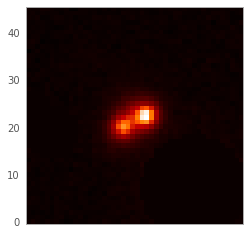

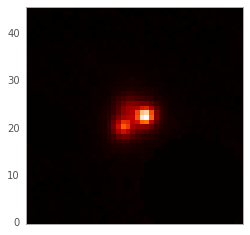

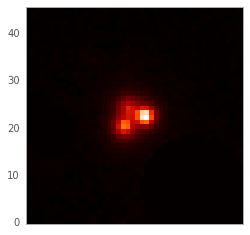

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
Converged after 174 iterations!
Best fit found:  -7423.370298263344 [0.965475171184613, 0.05030831749332319, 0.006415348479175073, 1.5407822532745565, 2.42471060170643, -0.08652765275952082, -0.023480521326271216, -0.27634263794791436, 0.1700000036703511, -0.6354464888265557, 0.6242119579166523, -0.7190017530166086, -0.05824456915034761]
-3.02562473945928 reduced X^2 of best position
-7423.370298263344 logL
4907.0 effective number of data points
[{'theta_E': 0.965475171184613, 'e1': 0.05030831749332319, 'e2': 0.006415348479175073, 'center_x': -0.27634263794791436, 'center_y': 0.1700000036703511}] lens result
[] source result
[{'amp': 1, 'R_sersic': 1.5407822532745565, 'n_sersic': 2.42471060170643, 'e1': -0.08652765275952082, 'e2': -0.023480521326271216, 'center_x': -0.27634263794791436, 'center_y': 0.1700000036703511}] lens light result
[{'ra_image': array([-0.63544649,  0.62421196]), 'dec_image': array([-

/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:43: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:136: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: divide by zero encountere

Check Positions: True
Check Fluxes: True
Check Positions: True
Check Fluxes: True


/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:136: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,


Check Positions: True
Check Fluxes: True


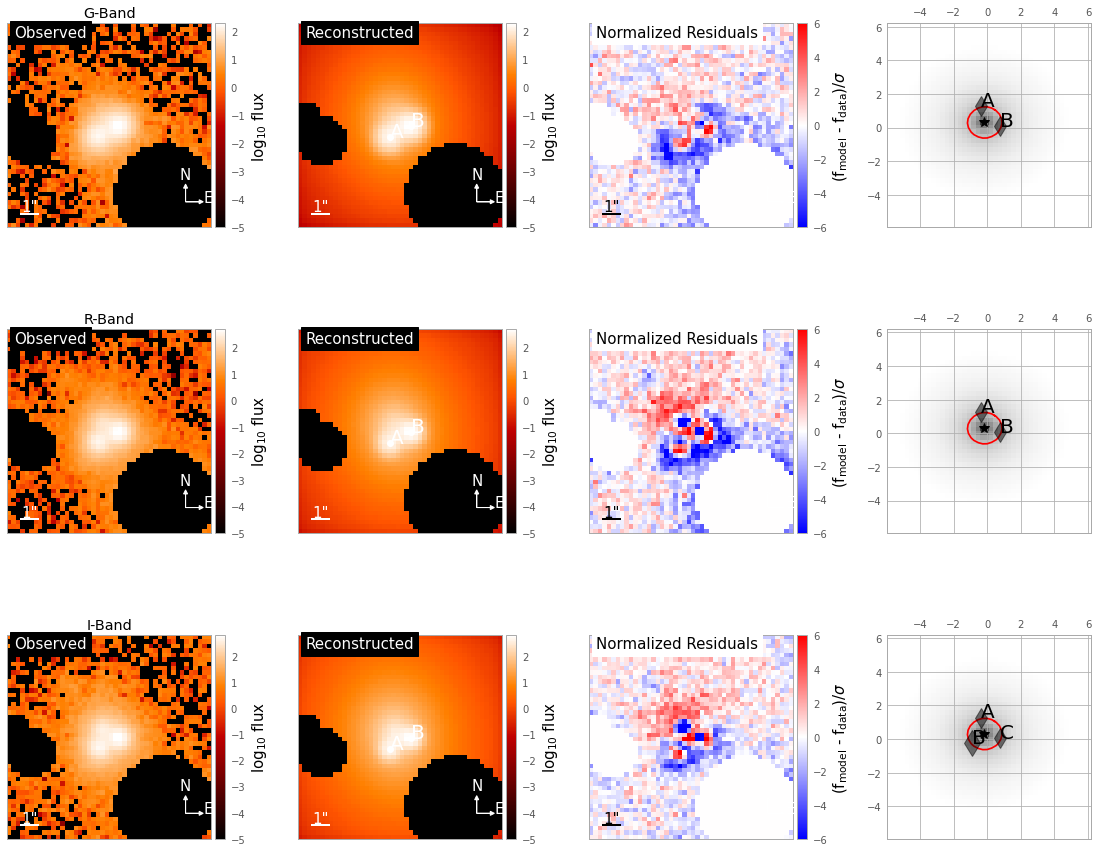

iteration of step 64 gave best reconstruction.
log likelihood before: -1992.774200130873 and log likelihood after: -1479.0939897693238
iteration of step 23 gave best reconstruction.
log likelihood before: -3247.208101855542 and log likelihood after: -2472.2348872556536
iteration of step 18 gave best reconstruction.
log likelihood before: -2183.3879873732726 and log likelihood after: -1947.9440245397716


/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/chain_plot.py:159: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(psf_error_map*psf_out**2), origin='lower', **kwargs)


-2.393699696313552 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  1.8004795980150017
reduced chi^2 of data  1 =  3.009415565740297
reduced chi^2 of data  2 =  2.371203925185358
The ray traced source positions are: 
ra: [-0.29339453 -0.29339119]
dec: [0.19446612 0.19447007]


/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:43: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:136: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,


Check Positions: True
Check Fluxes: True
Check Positions: True
Check Fluxes: True


/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:136: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning

Check Positions: True
Check Fluxes: True


<Figure size 432x288 with 0 Axes>

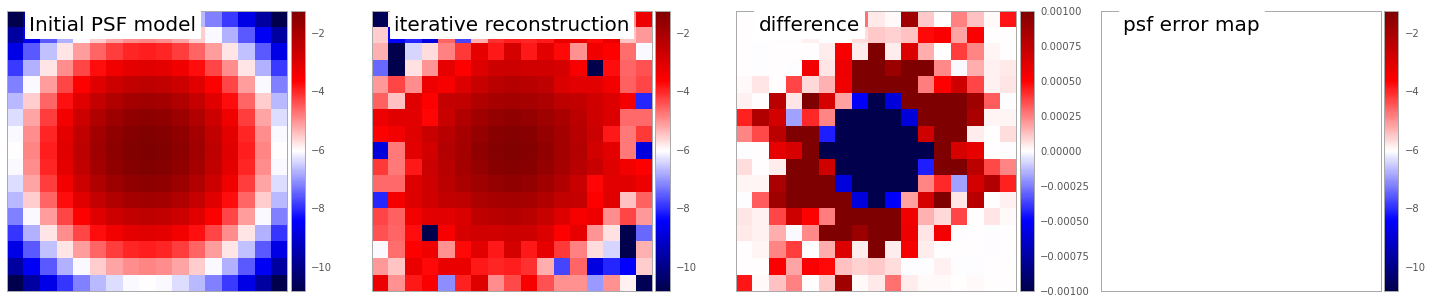

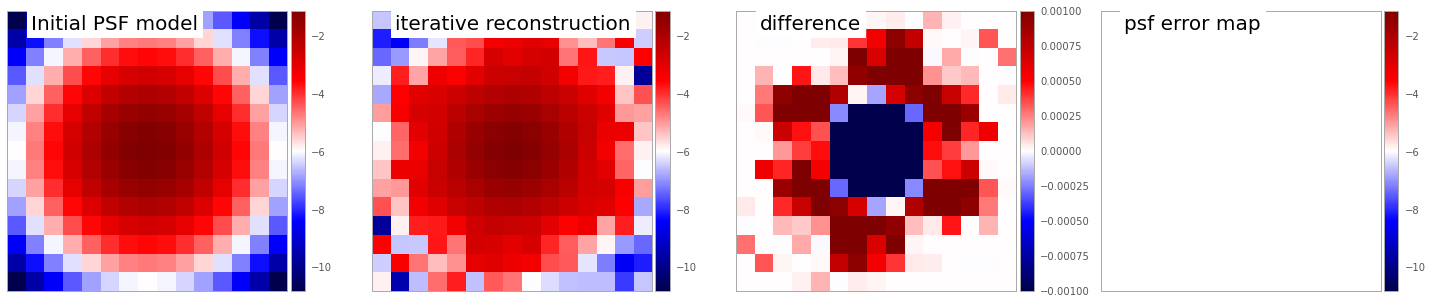

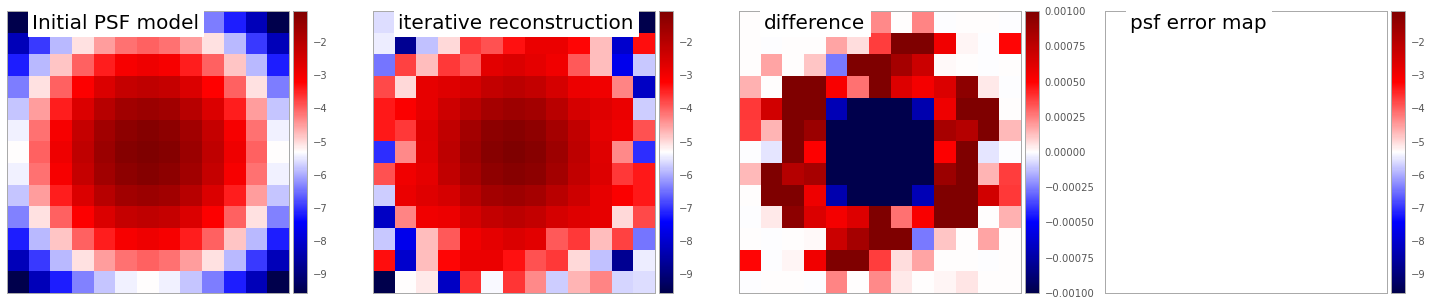

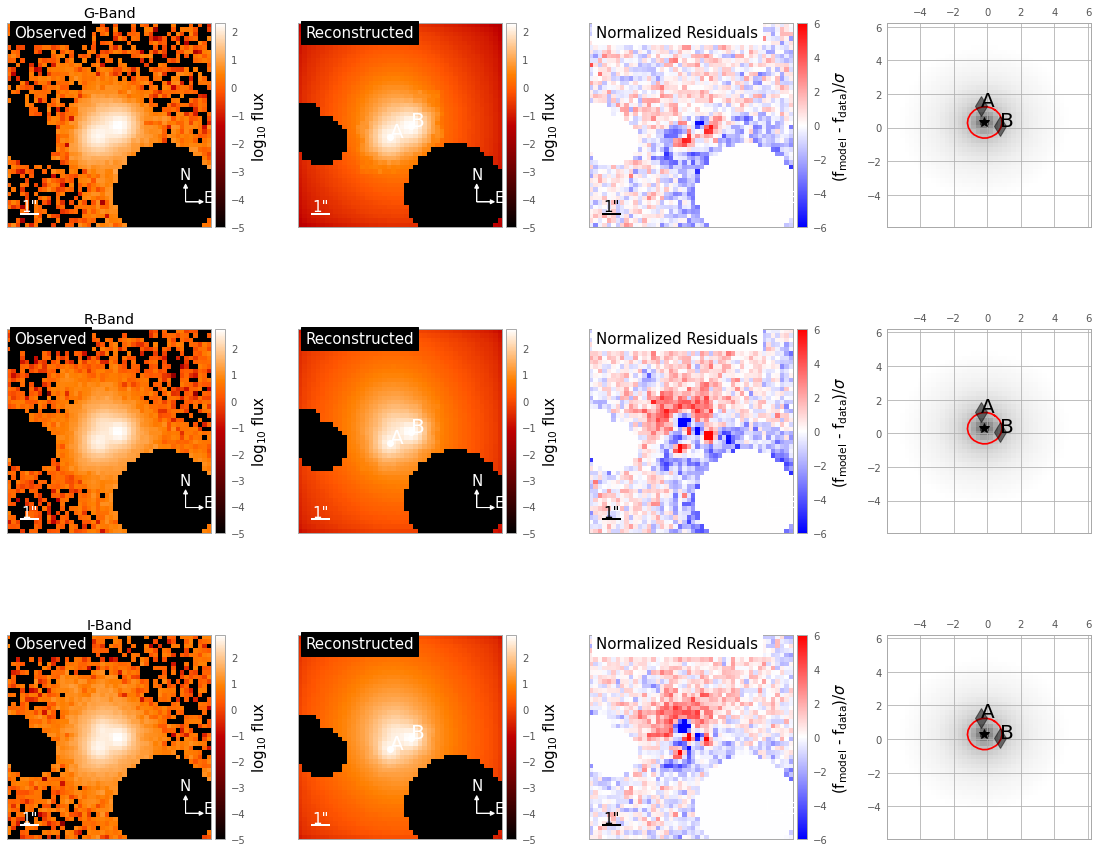

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
Converged after 155 iterations!
Best fit found:  -5504.375725471056 [0.9559338904219165, 0.0161581886947355, 0.015938561622552225, 1.5712047360246286, 2.853756543962265, -0.13307589833062738, -0.042964640315426246, -0.3036991732648214, 0.17000012573067672, -0.6447270935843227, 0.6110119324151395, -0.7105069701859692, -0.05021579203931134]
-2.243478999580622 reduced X^2 of best position
-5504.375725471056 logL
4907.0 effective number of data points
[{'theta_E': 0.9559338904219165, 'e1': 0.0161581886947355, 'e2': 0.015938561622552225, 'center_x': -0.3036991732648214, 'center_y': 0.17000012573067672}] lens result
[] source result
[{'amp': 1, 'R_sersic': 1.5712047360246286, 'n_sersic': 2.853756543962265, 'e1': -0.13307589833062738, 'e2': -0.042964640315426246, 'center_x': -0.3036991732648214, 'center_y': 0.17000012573067672}] lens light result
[{'ra_image': array([-0.64472709,  0.61101193]), 'dec_image': array([-0.710

100%|█████████████████████████████████████████| 800/800 [11:53<00:00,  1.12it/s]

Computing the MCMC...
Number of walkers =  130
Burn-in iterations:  200
Sampling iterations (in current run): 800
714.8166840076447 time taken for MCMC sampling
ra_images: [-0.63  0.61]
dec_images: [-0.71 -0.06]
-1.6419192118607207 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  1.3913811887959786
reduced chi^2 of data  1 =  1.9621128098207905
reduced chi^2 of data  2 =  1.5722636369653933



/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:43: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)


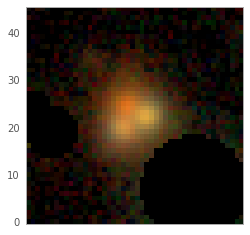

The ray traced source positions are: 
ra: [-0.39010929 -0.39004293]
dec: [0.38827978 0.388728  ]


/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:136: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning

Check Positions: True
Check Fluxes: True
Check Positions: True
Check Fluxes: True


/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:136: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,


Check Positions: True
Check Fluxes: True


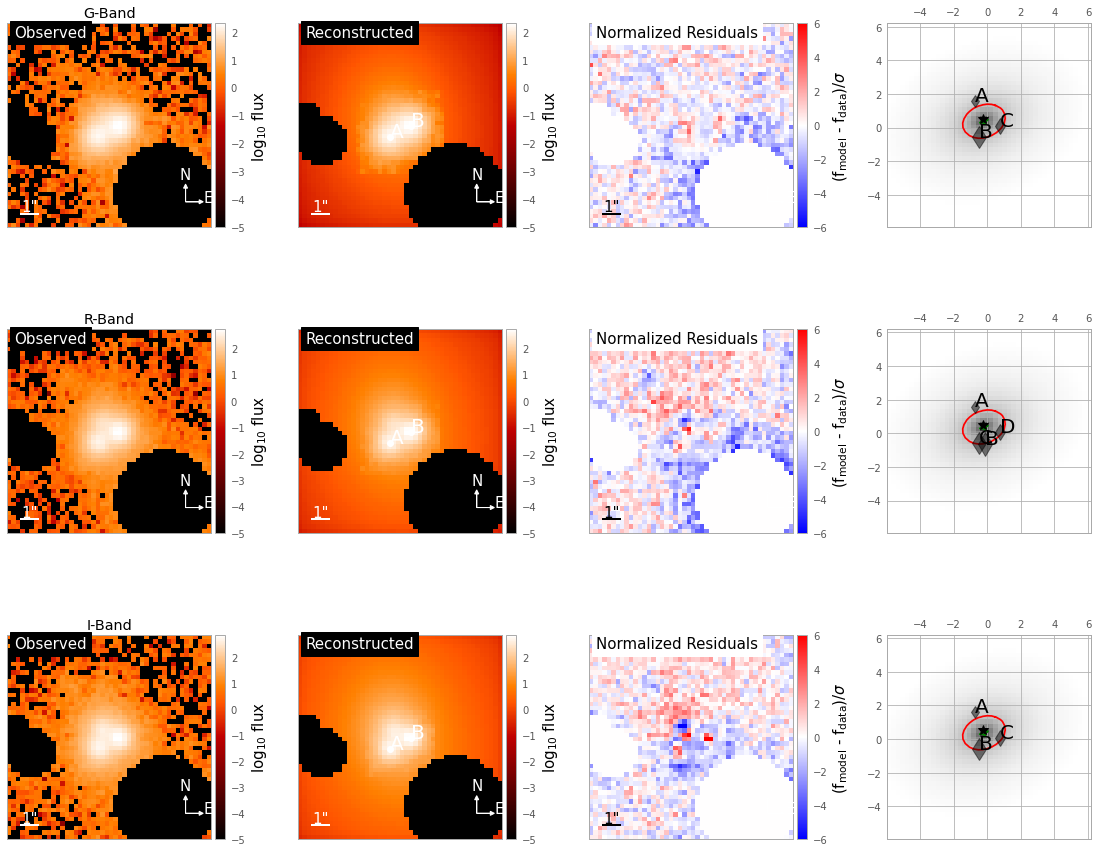

number of non-linear parameters in the MCMC process:  13
parameters in order:  ['theta_E_lens0', 'e1_lens0', 'e2_lens0', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'ra_image', 'ra_image', 'dec_image', 'dec_image']
number of evaluations in the MCMC process:  78000
78000


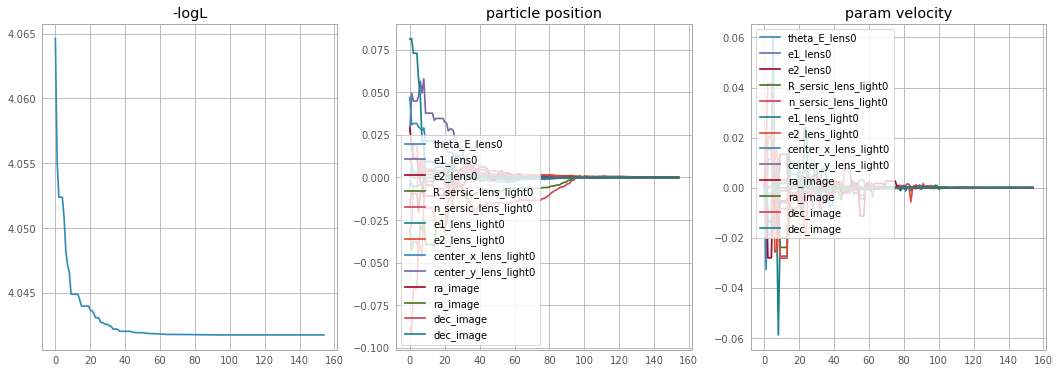

<Figure size 432x288 with 0 Axes>

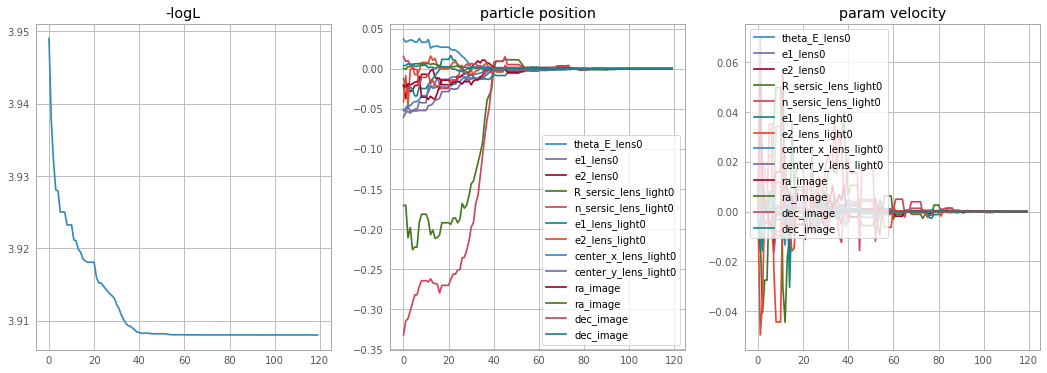

<Figure size 432x288 with 0 Axes>

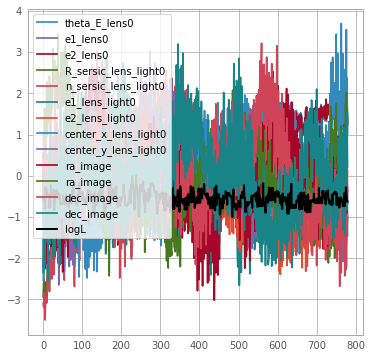

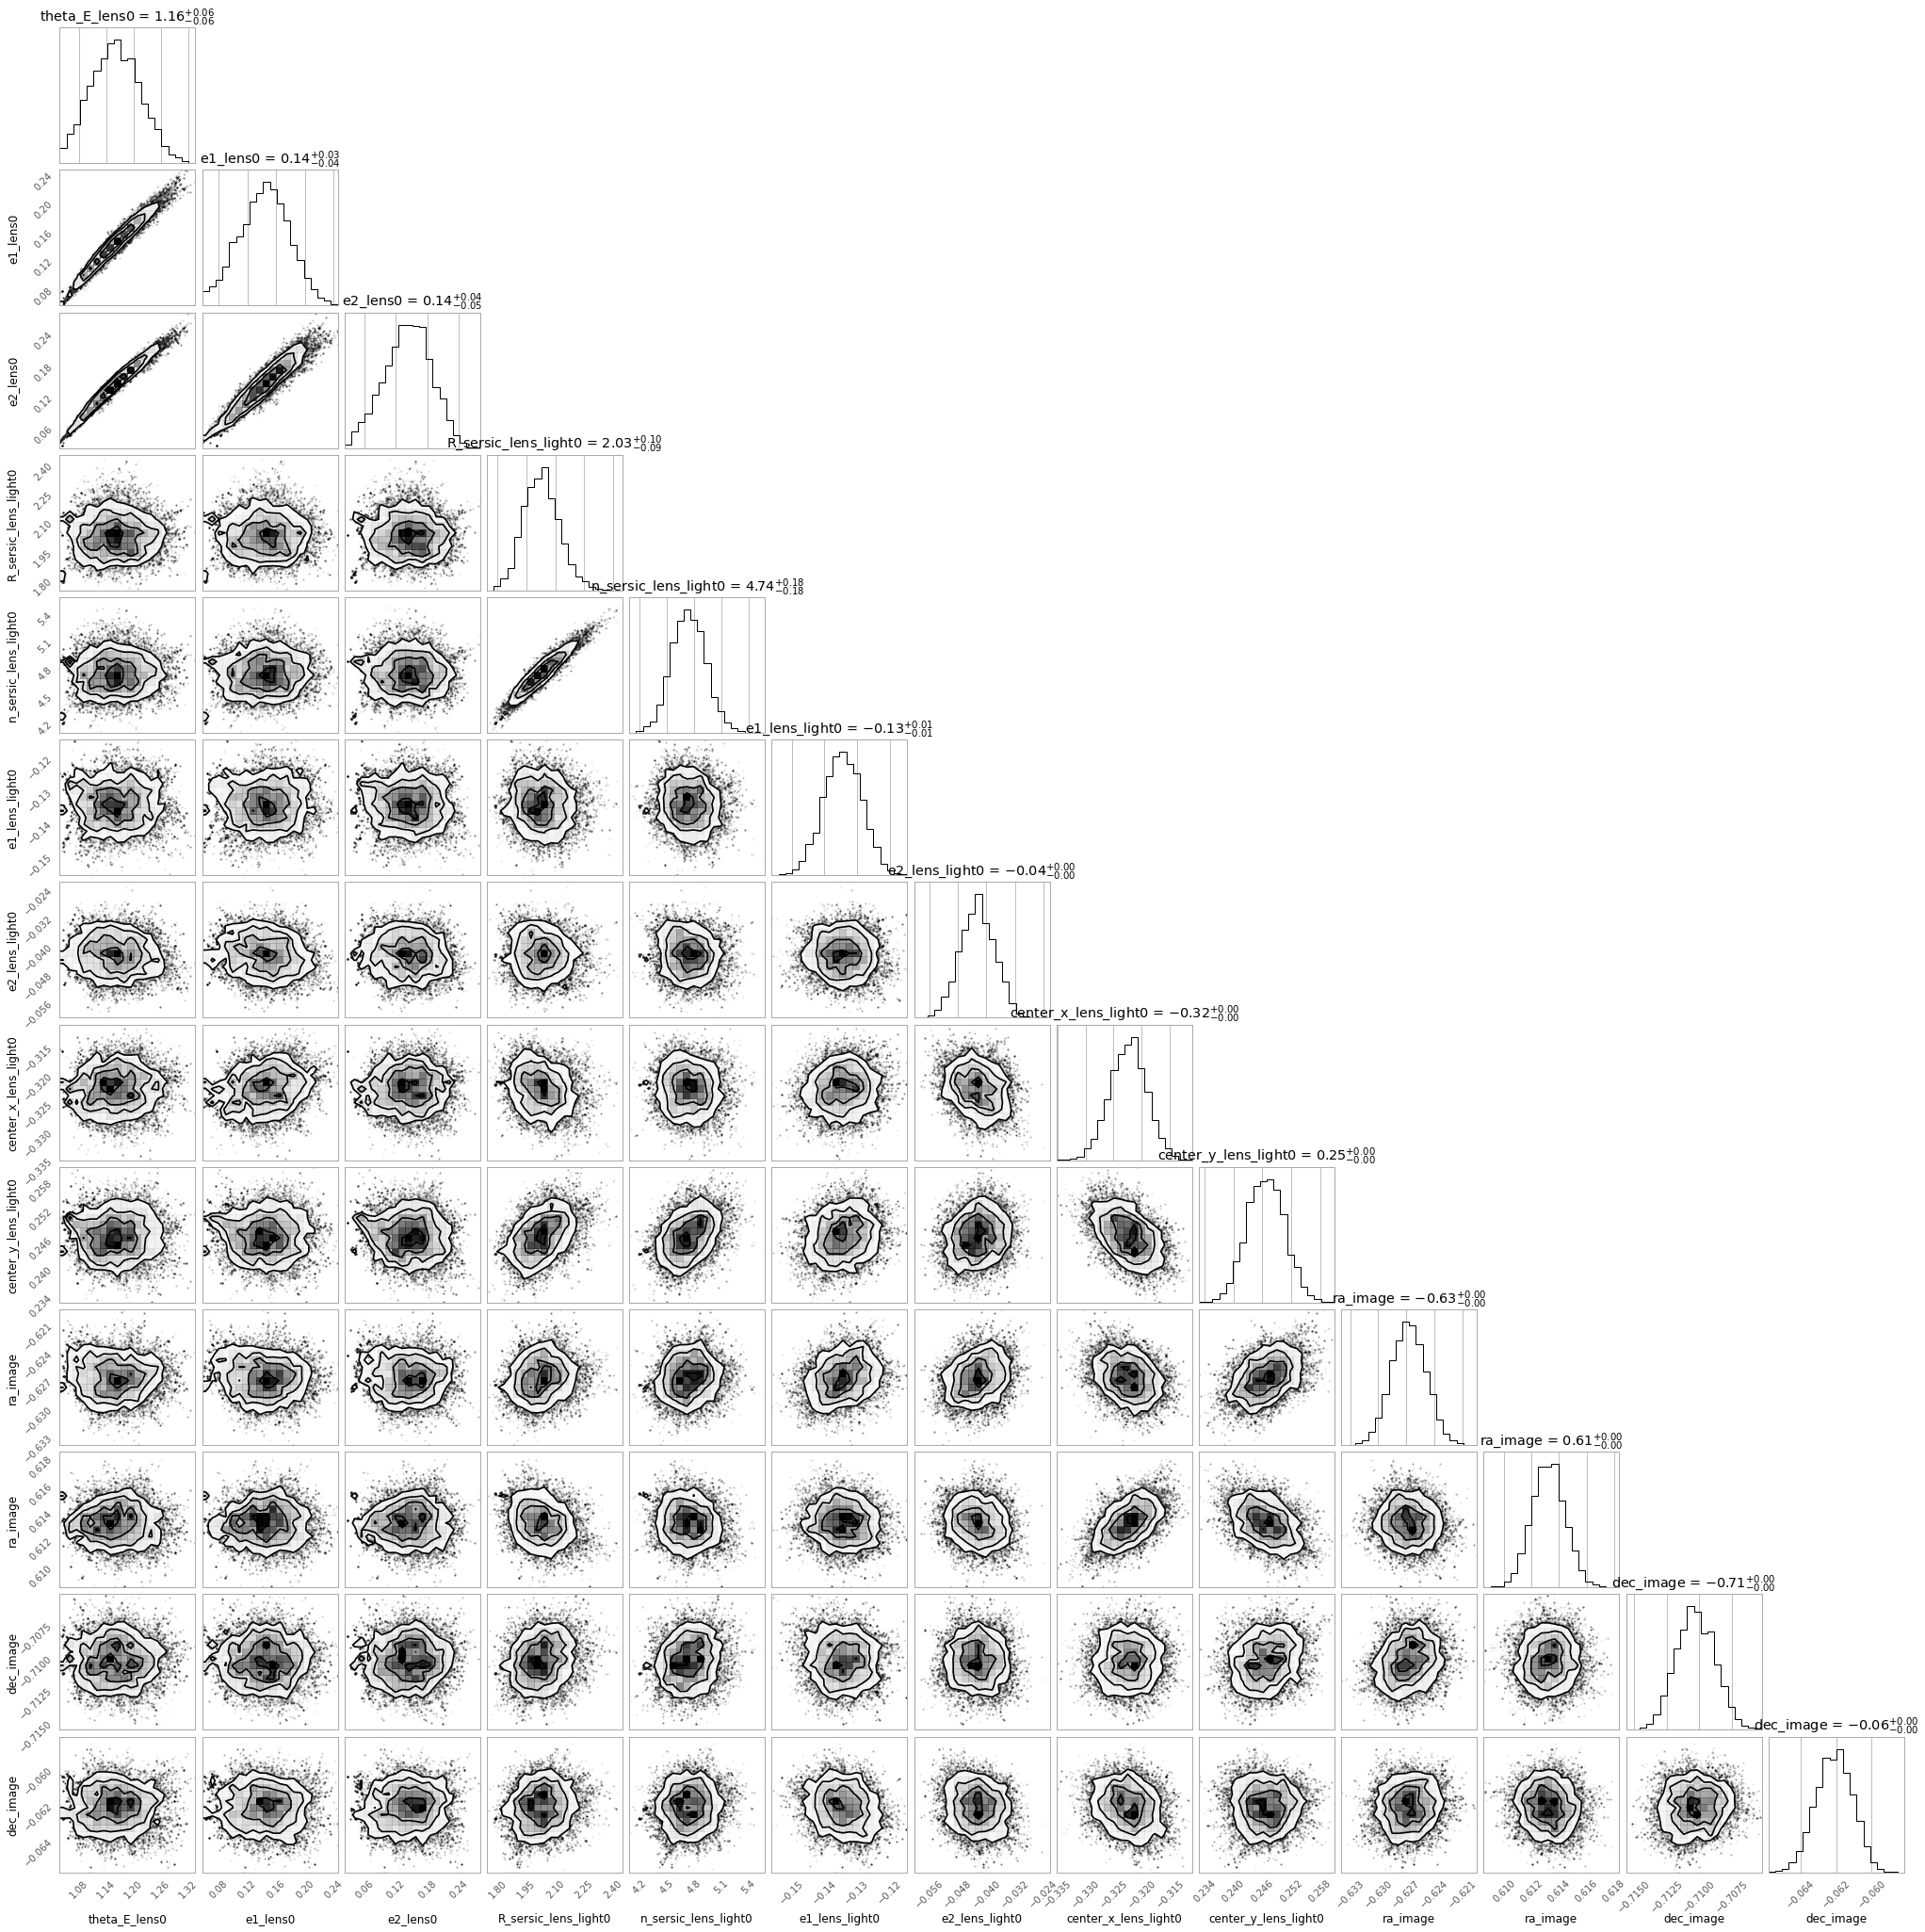

In [11]:
# set initial parameters
kwargs_lens_initial = {'theta_E': theta_E, 'e1': 0., 'e2': 0.,
                       'center_x': center_x, 'center_y': center_y}

kwargs_light_initial = {'R_sersic': 1., 'n_sersic': 2.,
                        'e1': 0., 'e2': 0.,
                        'center_x': center_x, 'center_y': center_y}

# run the model on the data
model(coadd_id, kwargs_lens_initial, kwargs_light_initial,
      x_images, y_images, psf_type, rms_list, mask_list)

Done! As you can see, our original estimated PSF model was too bright in the center, so the reconstruction did improve our PSF model. Also, the residuals show less of a 'bulls-eye' pattern. Of course, there is still some patterns in the residuals but that is mostly due to other noise.

However, it is important to note that in this process we have sacrificed two things: 
1. Computing time
2. The clarity of the reconstructed image

Now, we are also at risk of overfitting our image. It is up to you to decide how much complexity is needed in your model, and what is most important to model correctly. When modeling, often the simpler model is the better model.